In [55]:
import numpy as np
import pandas as pd

%pylab inline
%config InlineBackend.figure_formats = ['retina']

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle

Populating the interactive namespace from numpy and matplotlib


/home/grant/.local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [56]:
# load DF from pickle, reset index and drop extra column

WineDF = pickle.load( open( "data/FinalWineDF.pickle", "rb" ) )
WineDF = WineDF.reset_index()
WineDF = WineDF.drop('index',axis = 1)

In [57]:
# Pull out the non categoricals to plot and look at.

WineNonCat = WineDF[['price', 'year', 'ABV']]

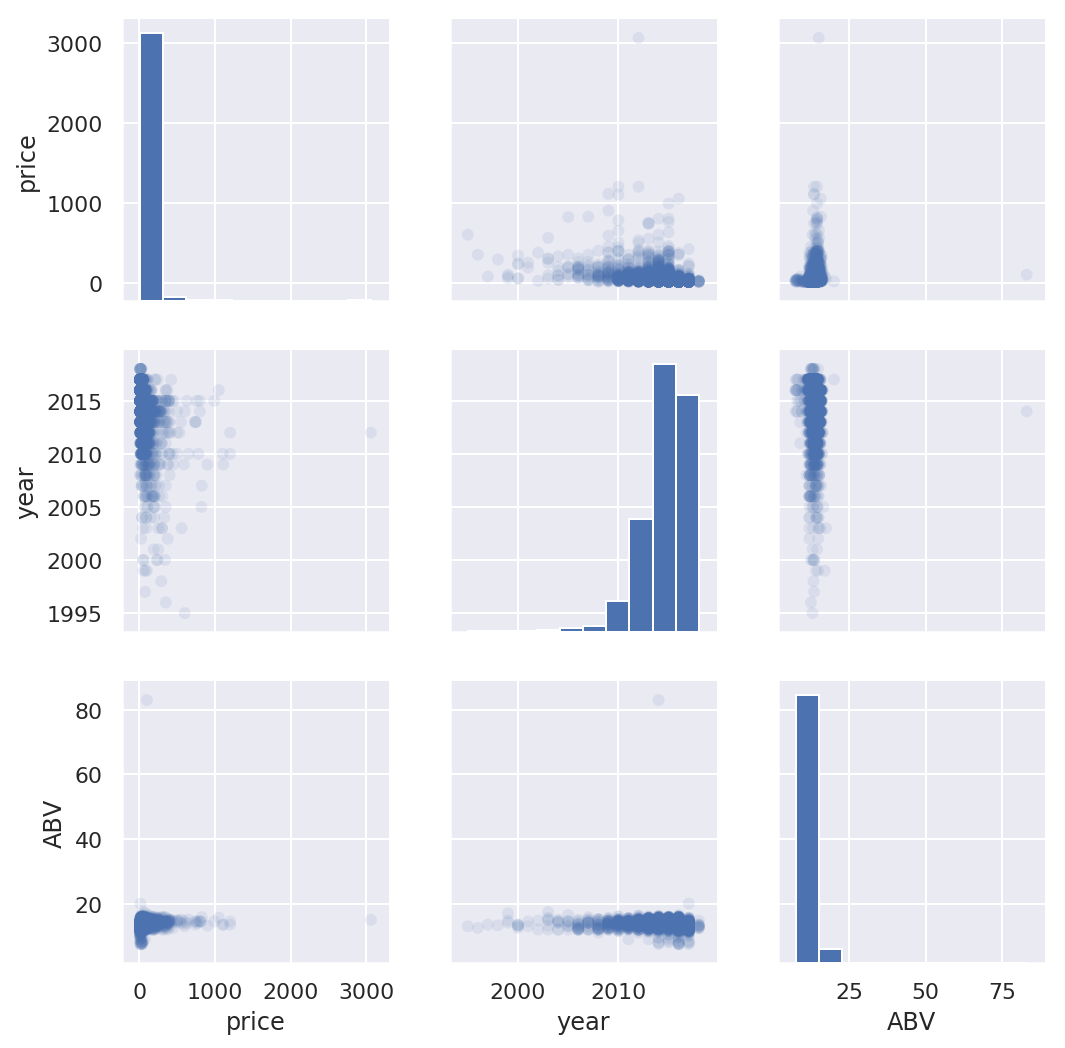

In [58]:
sns.pairplot(WineNonCat, plot_kws=dict(alpha=.1, edgecolor='none'));

In [59]:
# There are some weird values in price and ABV, so should drop those from the dataset.

WineNonCat.loc[WineNonCat['price'].idxmax()]

price    3058.97
year     2012.00
ABV        15.00
Name: 3329, dtype: float64

In [60]:
# Remove max value because it's way to high
WineDF = WineDF[WineDF['price'] < 3000]

In [61]:
WineNonCat.loc[WineNonCat['ABV'].idxmax()]

price      99.99
year     2014.00
ABV        83.00
Name: 118, dtype: float64

In [62]:
# Drop ABV value of that is too high at 83 and one at 20

WineDF = WineDF[WineDF['ABV'] < 20]
WineNonCat = WineDF[['price', 'year', 'ABV']]


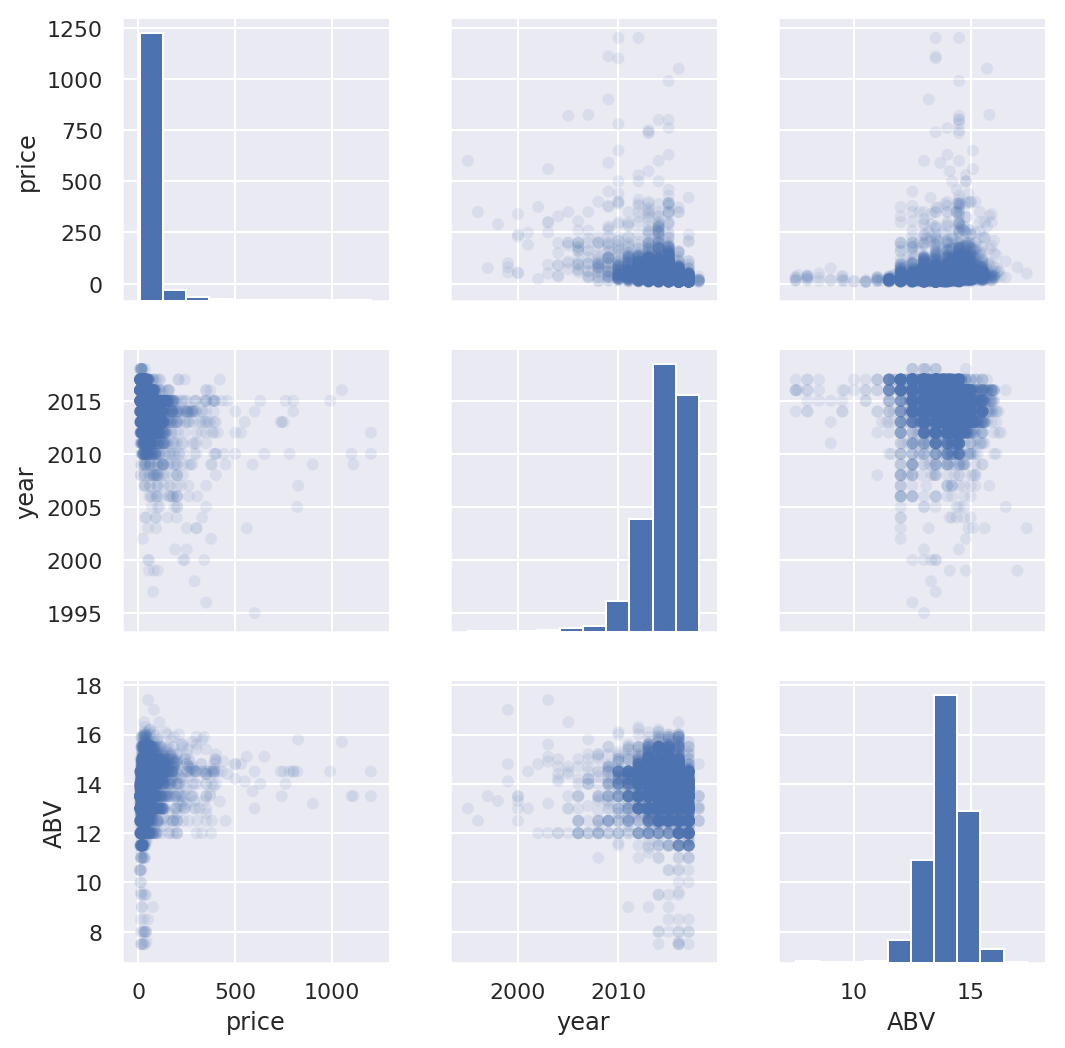

In [63]:
sns.pairplot(WineNonCat, plot_kws=dict(alpha=.1, edgecolor='none'));

In [64]:
# Check log of price
WineNonCat['log_price'] = WineNonCat.price.apply(np.log)
WineNonCat = WineNonCat.drop('price', axis=1)

/home/grant/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


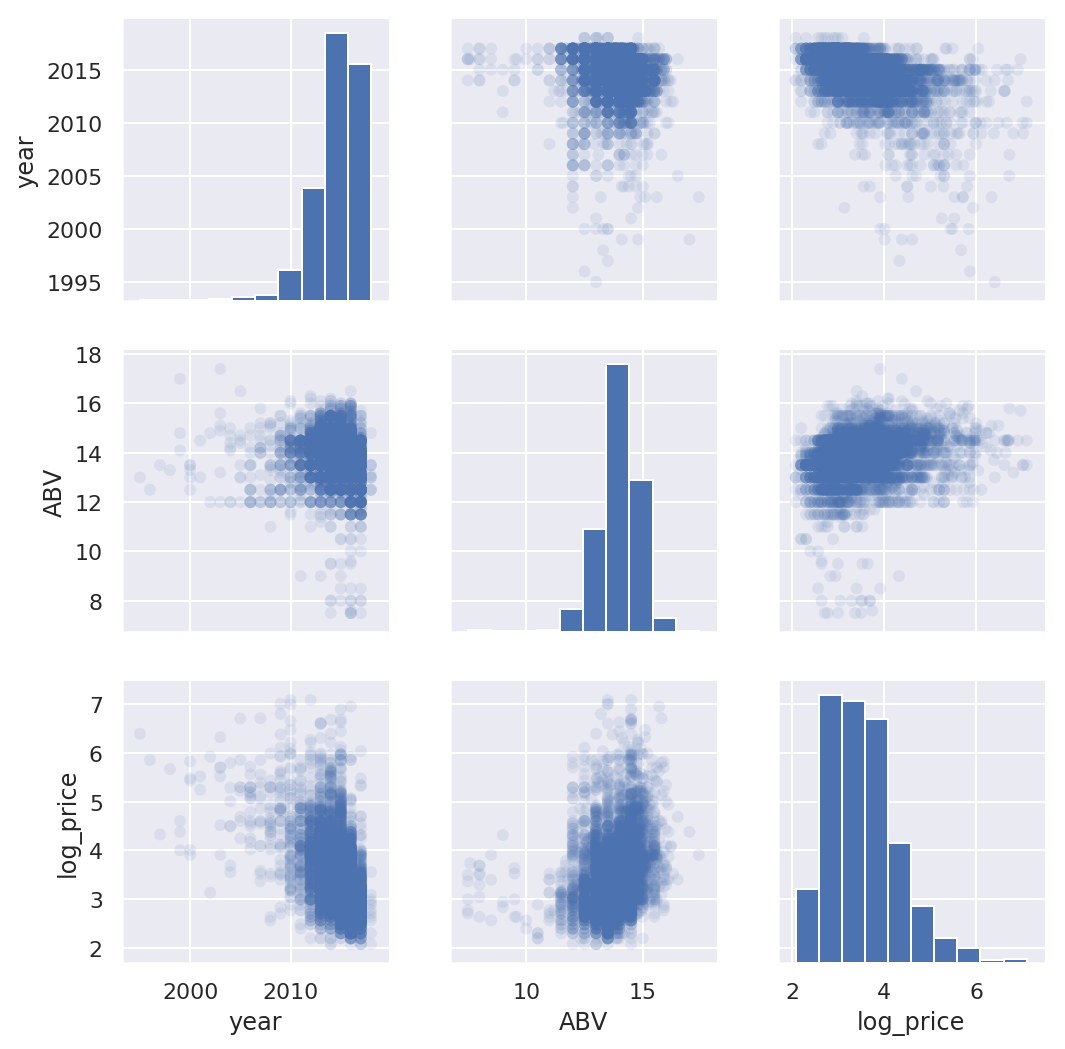

In [65]:
plot = sns.pairplot(WineNonCat, plot_kws=dict(alpha=.1, edgecolor='none'));
plot.savefig("pairplot.png")

In [66]:
# Log_price, ABV and year all look uncorrelated, so seems like a good place to start.
# Log_price and year are not quite normal, but they do seem to be good enough to start.

X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Split the rest of the data into 60% train, 20% cross validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

In [67]:
# Also run five fold cross validation on the training and cross-validation data to see if R^2 is consistent

Winelm = LinearRegression()

cross_val_score(Winelm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.59926598, 0.57582308, 0.60095215, 0.53164148, 0.56624095])

In [68]:
# Check the summary data for the training data to look at variables

lm1 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     109.9
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:13:28   Log-Likelihood:                -2267.2
No. Observations:                2970   AIC:                             4598.
Df Residuals:                    2938   BIC:                             4790.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0004      0.000      4.117      0.000       0.000       0.001
ABV                        0.1867      0.014     12.890      0.000       0.158       0.215
is_green                   0.0374      0.029      1.286      0.198      -0.020       0.094
is_collectable             1.0902      0.041     26.307      0.000       1.009       1.171
is_boutique                0.4007      0.026     15.437      0.000       0.350       0.452
is_screw                  -0.2358      0.032     -7.307      0.000      -0.299      -0.172
is_magnum                  0.9309      0.079     11.756      0.000       0.776       1.086
is_half                   -0.4051      0.102     -3.982      0.000      -0.605      -0.206
Cabernet Sauvignon        -0.1748      0.048     -3.622      0.000      -0.269      -0.080
Chardonnay                -0.3487      0.048     -7.196      0.000      -0.444      -0.254
Other Red Blends          -0.4992      0.054     -9.246      0.000      -0.605      -0.393
Pinot Gris/Grigio         -0.7541      0.075    -10.100      0.000      -0.901      -0.608
Pinot Noir                -0.2039      0.048     -4.230      0.000      -0.298      -0.109
Rhone Red Blends          -0.6102      0.066     -9.315      0.000      -0.739      -0.482
Riesling                  -0.2488      0.078     -3.176      0.002      -0.402      -0.095
Rosé                      -0.6116      0.065     -9.446      0.000      -0.739      -0.485
Sangiovese                -0.3109      0.084     -3.694      0.000      -0.476      -0.146
Sauvignon Blanc           -0.5678      0.060     -9.537      0.000      -0.685      -0.451
Syrah/Shiraz              -0.2114      0.060     -3.498      0.000      -0.330      -0.093
Vintage Sparkling Wine     0.4618      0.085      5.448      0.000       0.296       0.628
Zinfandel                 -0.6550      0.063    -10.333      0.000      -0.779      -0.531
Australia                  0.3536      0.088      4.014      0.000       0.181       0.526
California                 0.1982      0.073      2.725      0.006       0.056       0.341
Chile                     -0.1171      0.098     -1.192      0.233      -0.310       0.076
France                     0.5463      0.079      6.931      0.000       0.392       0.701
Italy                      0.3418      0.092      3.726      0.000       0.162       0.522
New Zealand                0.4336      0.094      4.610      0.000       0.249       0.618
Oregon                     0.3449      0.086      4.004      0.000       0.176       0.514
Other                      0.3396      0.093      3.662      0.000       0.158       0.521
South Africa               0.0529      0.112      0.471      0.638      -0.167       0.273
Spain                      0.1332      0.111      1.205      0.228      -0.084  

In [69]:
# is_green is possible not needed. I did check the categoricals that had higher P-values, but merging them
# into other made the adjusted R^2 worse.

X_train = X_train.drop('is_green',axis=1)

In [70]:
lm2 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     113.5
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:13:36   Log-Likelihood:                -2268.0
No. Observations:                2970   AIC:                             4598.
Df Residuals:                    2939   BIC:                             4784.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0004      0.000      4.141      0.000       0.000       0.001
ABV                        0.1864      0.014     12.873      0.000       0.158       0.215
is_collectable             1.0898      0.041     26.296      0.000       1.009       1.171
is_boutique                0.4024      0.026     15.523      0.000       0.352       0.453
is_screw                  -0.2342      0.032     -7.263      0.000      -0.297      -0.171
is_magnum                  0.9327      0.079     11.779      0.000       0.777       1.088
is_half                   -0.4037      0.102     -3.968      0.000      -0.603      -0.204
Cabernet Sauvignon        -0.1745      0.048     -3.615      0.000      -0.269      -0.080
Chardonnay                -0.3480      0.048     -7.180      0.000      -0.443      -0.253
Other Red Blends          -0.4998      0.054     -9.255      0.000      -0.606      -0.394
Pinot Gris/Grigio         -0.7541      0.075    -10.099      0.000      -0.901      -0.608
Pinot Noir                -0.2040      0.048     -4.232      0.000      -0.299      -0.109
Rhone Red Blends          -0.6078      0.065     -9.281      0.000      -0.736      -0.479
Riesling                  -0.2468      0.078     -3.150      0.002      -0.400      -0.093
Rosé                      -0.6114      0.065     -9.442      0.000      -0.738      -0.484
Sangiovese                -0.3111      0.084     -3.695      0.000      -0.476      -0.146
Sauvignon Blanc           -0.5684      0.060     -9.547      0.000      -0.685      -0.452
Syrah/Shiraz              -0.2112      0.060     -3.494      0.000      -0.330      -0.093
Vintage Sparkling Wine     0.4634      0.085      5.467      0.000       0.297       0.630
Zinfandel                 -0.6546      0.063    -10.326      0.000      -0.779      -0.530
Australia                  0.3597      0.088      4.089      0.000       0.187       0.532
California                 0.1998      0.073      2.748      0.006       0.057       0.342
Chile                     -0.1116      0.098     -1.137      0.255      -0.304       0.081
France                     0.5494      0.079      6.972      0.000       0.395       0.704
Italy                      0.3425      0.092      3.734      0.000       0.163       0.522
New Zealand                0.4403      0.094      4.687      0.000       0.256       0.624
Oregon                     0.3519      0.086      4.093      0.000       0.183       0.520
Other                      0.3392      0.093      3.658      0.000       0.157       0.521
South Africa               0.0521      0.112      0.465      0.642      -0.168       0.272
Spain                      0.1405      0.110      1.273      0.203      -0.076       0.357
Washington                -0.0436      0.084     -0.518      0.604      -0.209  

In [71]:
# Is green has no effect. Run the final model on both models to check!
X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # fit linear regression to training data
full_model = LinearRegression()
full_model.fit(X, y)
    
    # score fit model on validation data
val_score_full = full_model.score(X_test, y_test)
adjusted_r_squared = 1 - (1-val_score_full)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)   
# now drop is_green!

X, y = WineDF.drop('price',axis=1).drop('is_green', axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)


no_green_model = LinearRegression()
no_green_model.fit(X, y)
val_score_no_green = no_green_model.score(X_test,y_test)
adj_no_green = 1 - (1-val_score_no_green)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [72]:
print(val_score_full, adjusted_r_squared, val_score_no_green, adj_no_green)

0.5356506371266174 0.5201400112268803 0.5352266975013407 0.5202027429888709


In [73]:
# NOW! What about if we add more wine regions in California? Could split data into California, Napa, Sonoma, Central

In [74]:
# load DF from pickle, reset index and drop extra column

WineDF = pickle.load( open( "data/CaliforniaDF.pickle", "rb" ) )
WineDF = WineDF.reset_index()
WineDF = WineDF.drop('index',axis = 1)

In [75]:
# Remove max value because it's way to high
WineDF = WineDF[WineDF['price'] < 3000]
# Drop ABV value of that is too high at 83 and one at 20

WineDF = WineDF[WineDF['ABV'] < 20]

In [76]:
# Check again to verify that the outliers are gone
WineNonCat = WineDF[['price', 'year', 'ABV']]


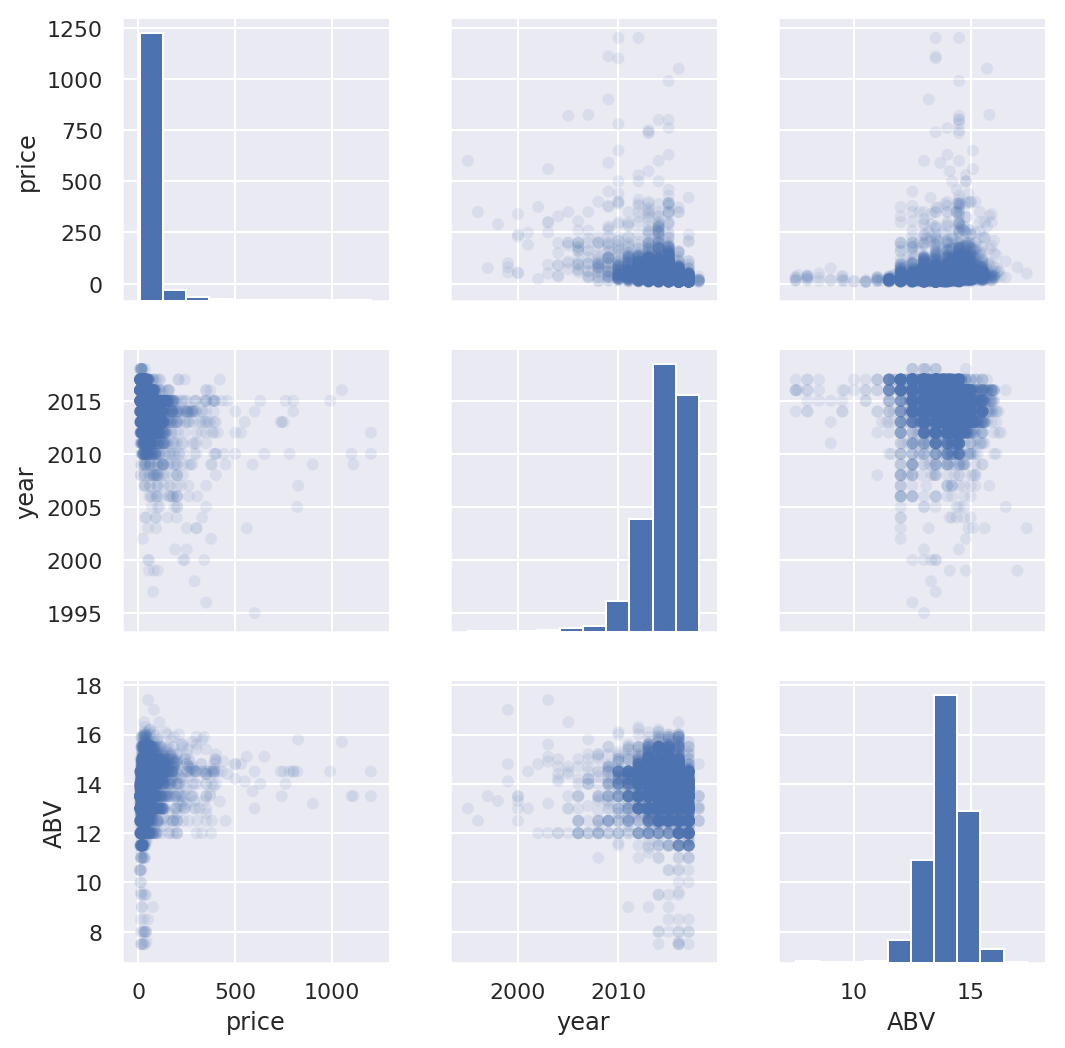

In [77]:
sns.pairplot(WineNonCat, plot_kws=dict(alpha=.1, edgecolor='none'));

In [78]:
# Log_price, ABV and year all look uncorrelated, so seems like a good place to start.
# Log_price and year are not quite normal, but they do seem to be good enough to start.

X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Split the rest of the data into 60% train, 20% cross validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

In [79]:
# Also run five fold cross validation on the training and cross-validation data to see if R^2 is consistent

Winelm = LinearRegression()

cross_val_score(Winelm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.62823675, 0.60422255, 0.6309506 , 0.57091891, 0.60683412])

In [80]:
# Check the summary data for the training data to look at variables

lm1 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     117.1
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:13:51   Log-Likelihood:                -2137.8
No. Observations:                2970   AIC:                             4346.
Df Residuals:                    2935   BIC:                             4555.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0006   9.77e-05      6.054      0.000       0.000       0.001
ABV                        0.1551      0.014     11.071      0.000       0.128       0.183
is_green                   0.0500      0.028      1.789      0.074      -0.005       0.105
is_collectable             1.0507      0.040     26.396      0.000       0.973       1.129
is_boutique                0.3675      0.025     14.692      0.000       0.318       0.417
is_screw                  -0.2269      0.031     -7.336      0.000      -0.288      -0.166
is_magnum                  0.8577      0.076     11.277      0.000       0.709       1.007
is_half                   -0.4587      0.098     -4.703      0.000      -0.650      -0.267
Bordeaux Red Blends        0.0917      0.047      1.947      0.052      -0.001       0.184
Cabernet Sauvignon        -0.1542      0.037     -4.152      0.000      -0.227      -0.081
Chardonnay                -0.1931      0.032     -6.115      0.000      -0.255      -0.131
Other Red Blends          -0.3185      0.042     -7.525      0.000      -0.402      -0.236
Pinot Gris/Grigio         -0.5898      0.061     -9.605      0.000      -0.710      -0.469
Rhone Red Blends          -0.4072      0.058     -7.079      0.000      -0.520      -0.294
Riesling                  -0.1326      0.066     -2.013      0.044      -0.262      -0.003
Rosé                      -0.4655      0.052     -8.993      0.000      -0.567      -0.364
Sangiovese                -0.1574      0.076     -2.076      0.038      -0.306      -0.009
Sauvignon Blanc           -0.4953      0.046    -10.837      0.000      -0.585      -0.406
Syrah/Shiraz              -0.0390      0.050     -0.778      0.437      -0.137       0.059
Vintage Sparkling Wine     0.5930      0.075      7.897      0.000       0.446       0.740
Zinfandel                 -0.4422      0.051     -8.595      0.000      -0.543      -0.341
Argentina                  0.0422      0.072      0.585      0.559      -0.099       0.184
Australia                  0.3440      0.056      6.179      0.000       0.235       0.453
Central Coast              0.1244      0.033      3.736      0.000       0.059       0.190
Chile                     -0.0849      0.070     -1.216      0.224      -0.222       0.052
France                     0.5272      0.041     12.922      0.000       0.447       0.607
Italy                      0.3222      0.061      5.298      0.000       0.203       0.441
Napa Valley                0.6138      0.039     15.930      0.000       0.538       0.689
New Zealand                0.3946      0.063      6.272      0.000       0.271       0.518
Oregon                     0.2983      0.050      5.936      0.000       0.200       0.397
Other                      0.2860      0.062      4.578      0.000       0.164  

In [81]:
# adjusted R squared is higher! Using more areas helped!

X_train = X_train.drop('is_green',axis=1)

In [82]:
lm2 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     120.5
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:13:51   Log-Likelihood:                -2139.4
No. Observations:                2970   AIC:                             4347.
Df Residuals:                    2936   BIC:                             4551.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0006   9.77e-05      6.093      0.000       0.000       0.001
ABV                        0.1549      0.014     11.050      0.000       0.127       0.182
is_collectable             1.0506      0.040     26.383      0.000       0.973       1.129
is_boutique                0.3699      0.025     14.805      0.000       0.321       0.419
is_screw                  -0.2250      0.031     -7.276      0.000      -0.286      -0.164
is_magnum                  0.8599      0.076     11.303      0.000       0.711       1.009
is_half                   -0.4566      0.098     -4.681      0.000      -0.648      -0.265
Bordeaux Red Blends        0.0919      0.047      1.949      0.051      -0.001       0.184
Cabernet Sauvignon        -0.1532      0.037     -4.125      0.000      -0.226      -0.080
Chardonnay                -0.1917      0.032     -6.071      0.000      -0.254      -0.130
Other Red Blends          -0.3191      0.042     -7.537      0.000      -0.402      -0.236
Pinot Gris/Grigio         -0.5896      0.061     -9.598      0.000      -0.710      -0.469
Rhone Red Blends          -0.4043      0.058     -7.029      0.000      -0.517      -0.292
Riesling                  -0.1297      0.066     -1.970      0.049      -0.259      -0.001
Rosé                      -0.4652      0.052     -8.983      0.000      -0.567      -0.364
Sangiovese                -0.1575      0.076     -2.077      0.038      -0.306      -0.009
Sauvignon Blanc           -0.4958      0.046    -10.844      0.000      -0.585      -0.406
Syrah/Shiraz              -0.0387      0.050     -0.773      0.439      -0.137       0.059
Vintage Sparkling Wine     0.5954      0.075      7.927      0.000       0.448       0.743
Zinfandel                 -0.4408      0.051     -8.567      0.000      -0.542      -0.340
Argentina                  0.0398      0.072      0.551      0.582      -0.102       0.181
Australia                  0.3501      0.056      6.297      0.000       0.241       0.459
Central Coast              0.1264      0.033      3.795      0.000       0.061       0.192
Chile                     -0.0799      0.070     -1.146      0.252      -0.217       0.057
France                     0.5291      0.041     12.967      0.000       0.449       0.609
Italy                      0.3210      0.061      5.276      0.000       0.202       0.440
Napa Valley                0.6130      0.039     15.902      0.000       0.537       0.689
New Zealand                0.4014      0.063      6.389      0.000       0.278       0.525
Oregon                     0.3055      0.050      6.094      0.000       0.207       0.404
Other                      0.2835      0.062      4.537      0.000       0.161       0.406
Sonoma County              0.2451      0.034      7.198      0.000       0.178  

In [83]:
# This time is green had a very small effect. Run the final model on both models to check!
X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # fit linear regression to training data
full_model = LinearRegression()
full_model.fit(X, y)
    
    # score fit model on validation data
val_score_full = full_model.score(X_test, y_test)
adjusted_r_squared = 1 - (1-val_score_full)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)    
# now drop is_green!

X, y = WineDF.drop('price',axis=1).drop('is_green', axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)


no_green_model = LinearRegression()
no_green_model.fit(X, y)
val_score_no_green = no_green_model.score(X_test,y_test)
adj_no_green= 1 - (1-val_score_no_green)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [84]:
print(val_score_full, adjusted_r_squared, val_score_no_green, adj_no_green)

0.5667364987543033 0.5508577316929427 0.5659100109793156 0.5504716640894587


In [85]:
# practically the same again, but CAN WE DO BETTER? This time I filled the missing ABV values with draws
# from a normal distribution with the mean and standard deviation of each varietal in order to double 
# my data!

In [86]:
# load DF from pickle, reset index and drop extra column

WineDF = pickle.load( open( "data/CaliforniaFullDF.pickle", "rb" ) )
WineDF = WineDF.reset_index()
WineDF = WineDF.drop('index',axis = 1)

In [87]:
WineDF.tail()

,price,year,ABV,is_green,is_collectable,is_boutique,is_screw,is_magnum,is_half,Bordeaux Red Blends,...,Germany,Italy,Napa Valley,New Zealand,Oregon,Other,Sonoma County,South Africa,Spain,Washington
10194,225.00,2011,14.071361,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10195,49.98,2004,14.071361,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10196,8.99,2015,14.071361,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10197,53.99,2014,14.071361,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10198,250.00,2009,14.071361,1,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [88]:
# Remove max value because it's way to high
WineDF = WineDF[WineDF['price'] < 3000]
# Drop ABV value of that is too high at 83 and one at 20

WineDF = WineDF[WineDF['ABV'] < 20]

In [89]:
# Check again to verify that the outliers are gone
WineNonCat = WineDF[['price', 'year', 'ABV']]
WineNonCat['price'] = WineDF['price'].apply(np.log)

/home/grant/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


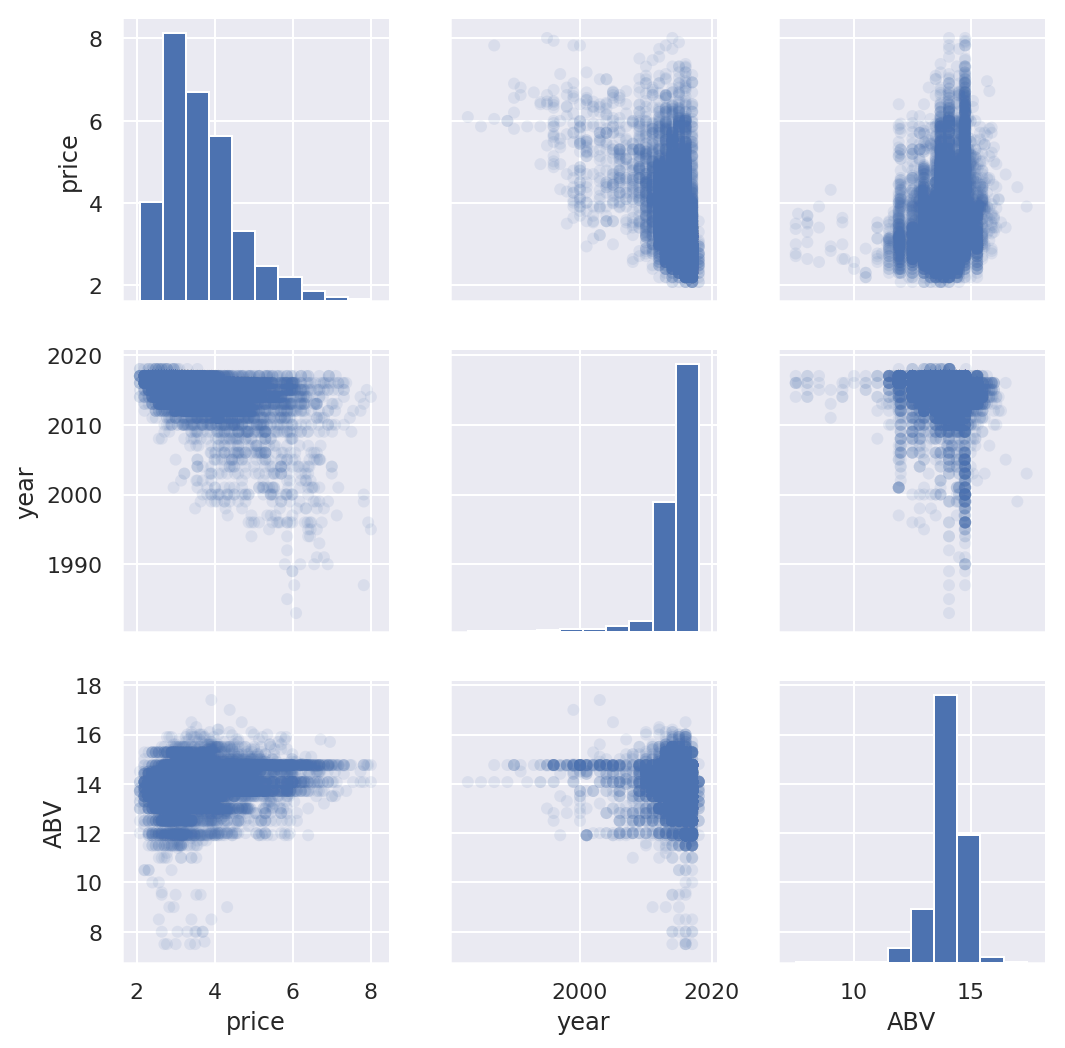

In [90]:
plot = sns.pairplot(WineNonCat, plot_kws=dict(alpha=.1, edgecolor='none'));
plot.savefig("pairplot2.png")

In [91]:
# Log_price, ABV and year all look uncorrelated, so seems like a good place to start.
# Log_price and year are not quite normal, but they do seem to be good enough to start.

X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Split the rest of the data into 60% train, 20% cross validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43)

In [92]:
# Also run five fold cross validation on the training and cross-validation data to see if R^2 is consistent

Winelm = LinearRegression()

cross_val_score(Winelm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')

array([0.59974078, 0.67349746, 0.65123959, 0.65609819, 0.65356441])

In [93]:
# Check the summary data for the training data to look at variables

lm1 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     288.0
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:14:01   Log-Likelihood:                -5161.0
No. Observations:                6119   AIC:                         1.039e+04
Df Residuals:                    6083   BIC:                         1.064e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0008   9.92e-05      8.411      0.000       0.001       0.001
ABV                        0.1169      0.014      8.137      0.000       0.089       0.145
is_green                   0.0071      0.022      0.315      0.753      -0.037       0.051
is_collectable             1.1885      0.026     45.197      0.000       1.137       1.240
is_boutique                0.4139      0.021     19.841      0.000       0.373       0.455
is_screw                  -0.2265      0.027     -8.525      0.000      -0.279      -0.174
is_magnum                  0.9431      0.047     20.094      0.000       0.851       1.035
is_half                   -0.3576      0.070     -5.116      0.000      -0.495      -0.221
Bordeaux Red Blends       -0.1168      0.034     -3.429      0.001      -0.184      -0.050
Cabernet Sauvignon        -0.2034      0.031     -6.609      0.000      -0.264      -0.143
Chardonnay                -0.2408      0.025     -9.617      0.000      -0.290      -0.192
Other Red Blends          -0.3804      0.036    -10.594      0.000      -0.451      -0.310
Pinot Gris/Grigio         -0.6979      0.051    -13.589      0.000      -0.799      -0.597
Rhone Red Blends          -0.5161      0.040    -13.061      0.000      -0.594      -0.439
Riesling                  -0.2729      0.063     -4.321      0.000      -0.397      -0.149
Rosé                      -0.5965      0.042    -14.065      0.000      -0.680      -0.513
Sangiovese                -0.2551      0.058     -4.380      0.000      -0.369      -0.141
Sauvignon Blanc           -0.6432      0.035    -18.244      0.000      -0.712      -0.574
Syrah/Shiraz              -0.1453      0.039     -3.738      0.000      -0.222      -0.069
Vintage Sparkling Wine     0.3211      0.065      4.915      0.000       0.193       0.449
Zinfandel                 -0.5187      0.047    -11.088      0.000      -0.610      -0.427
Argentina                  0.0204      0.057      0.360      0.719      -0.091       0.131
Australia                  0.3293      0.048      6.793      0.000       0.234       0.424
Central Coast              0.2062      0.030      6.927      0.000       0.148       0.265
Chile                     -0.0533      0.053     -1.005      0.315      -0.157       0.051
France                     0.6325      0.027     23.499      0.000       0.580       0.685
Germany                    0.4487      0.092      4.859      0.000       0.268       0.630
Italy                      0.3361      0.046      7.293      0.000       0.246       0.426
Napa Valley                0.7480      0.032     23.398      0.000       0.685       0.811
New Zealand                0.3995      0.056      7.182      0.000       0.290       0.508
Oregon                     0.3153      0.046      6.861      0.000       0.225  

In [94]:
# BOOM! adjusted R squared is higher! Using more data helped!

X_train = X_train.drop('is_green',axis=1)

In [95]:
lm2 = sm.OLS(y_train,X_train,hasconst=True)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     296.5
Date:                Sun, 27 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:14:01   Log-Likelihood:                -5161.0
No. Observations:                6119   AIC:                         1.039e+04
Df Residuals:                    6084   BIC:                         1.063e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
year                       0.0008   9.91e-05      8.422      0.000       0.001       0.001
ABV                        0.1168      0.014      8.134      0.000       0.089       0.145
is_collectable             1.1883      0.026     45.203      0.000       1.137       1.240
is_boutique                0.4141      0.021     19.864      0.000       0.373       0.455
is_screw                  -0.2262      0.027     -8.520      0.000      -0.278      -0.174
is_magnum                  0.9432      0.047     20.097      0.000       0.851       1.035
is_half                   -0.3571      0.070     -5.110      0.000      -0.494      -0.220
Bordeaux Red Blends       -0.1172      0.034     -3.442      0.001      -0.184      -0.050
Cabernet Sauvignon        -0.2034      0.031     -6.612      0.000      -0.264      -0.143
Chardonnay                -0.2408      0.025     -9.618      0.000      -0.290      -0.192
Other Red Blends          -0.3805      0.036    -10.597      0.000      -0.451      -0.310
Pinot Gris/Grigio         -0.6980      0.051    -13.592      0.000      -0.799      -0.597
Rhone Red Blends          -0.5156      0.039    -13.059      0.000      -0.593      -0.438
Riesling                  -0.2723      0.063     -4.314      0.000      -0.396      -0.149
Rosé                      -0.5966      0.042    -14.068      0.000      -0.680      -0.513
Sangiovese                -0.2552      0.058     -4.381      0.000      -0.369      -0.141
Sauvignon Blanc           -0.6432      0.035    -18.244      0.000      -0.712      -0.574
Syrah/Shiraz              -0.1451      0.039     -3.733      0.000      -0.221      -0.069
Vintage Sparkling Wine     0.3217      0.065      4.926      0.000       0.194       0.450
Zinfandel                 -0.5186      0.047    -11.086      0.000      -0.610      -0.427
Argentina                  0.0204      0.057      0.360      0.719      -0.091       0.131
Australia                  0.3296      0.048      6.800      0.000       0.235       0.425
Central Coast              0.2063      0.030      6.931      0.000       0.148       0.265
Chile                     -0.0528      0.053     -0.995      0.320      -0.157       0.051
France                     0.6328      0.027     23.520      0.000       0.580       0.686
Germany                    0.4479      0.092      4.852      0.000       0.267       0.629
Italy                      0.3359      0.046      7.289      0.000       0.246       0.426
Napa Valley                0.7480      0.032     23.401      0.000       0.685       0.811
New Zealand                0.4005      0.056      7.213      0.000       0.292       0.509
Oregon                     0.3166      0.046      6.915      0.000       0.227       0.406
Other                      0.2690      0.059      4.545      0.000       0.153  

In [96]:
# This time is green has no effect. Run the final model on both models to check!
X, y = WineDF.drop('price',axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # fit linear regression to training data
full_model = LinearRegression()
full_model.fit(X, y)
    
    # score fit model on validation data
val_score_full = full_model.score(X_test, y_test)
adjusted_r_squared = 1 - (1-val_score_full)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

# now drop is_green!

X, y = WineDF.drop('price',axis=1).drop('is_green', axis=1), WineDF['price'].apply(np.log)

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)


no_green_model = LinearRegression()
no_green_model.fit(X, y)
val_score_no_green = no_green_model.score(X_test,y_test)

In [97]:
adj_no_green = 1 - (1-val_score_no_green)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [98]:
print(val_score_full, adjusted_r_squared, val_score_no_green, adj_no_green)

# Very similar! I think this is where to end as I'm using all the data I scraped!

0.6477586797474689 0.6414278322541633 0.6474913091623371 0.6413347202505018
